In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../../src')
from rdkit import Chem
from dfs_transformer.utils import Smiles2Mol, Mol2Smiles, DFSCode2Graph, Graph2Mol, isValid, Smiles2DFSCode, DFSCode2Smiles, isValidMoleculeDFSCode
from dfs_transformer.utils import load_selfattn_wandb, load_selfattn_local, computeChemicalValidityAndNovelty, parseChempropAtomFeatures, parseChempropBondFeatures
from dfs_transformer.utils import FeaturizedDFSCodes2Nx, Mol2Nx, Nx2Mol
import os.path
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import dfs_transformer as dfs
import numpy as np
from ml_collections import ConfigDict
import yaml
import functools
import tqdm
import traceback

2022-01-25 16:28:00.095844: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/cuda/extras/CUPTI/lib64/:/opt/intel/lib:/opt/intel/mkl/lib/intel64:/opt/intel:/opt/ibm/ILOG/CPLEX_Studio1210/cplex/bin/x86-64_linux:/opt/ibm/ILOG/CPLEX_Studio1210/cplex/python/3.7/x86-64_linux:/opt/intel/clck_latest/lib:/opt/intel/daal/lib:/opt/intel/intelpython3/lib:/opt/intel/ipp/lib:/opt/intel/itac_2019/lib:/opt/intel/itac_latest/lib:/opt/intel/mkl/lib:/opt/intel/mkl_/lib:/opt/intel/mpirt/lib:/opt/intel/tbb/lib:/opt/intel/clck/2019.0/lib:/opt/intel/compilers_and_libraries_2019/linux/lib:/opt/intel/compilers_and_libraries/linux/lib:/opt/intel/itac/2019.0.018/lib:/opt/intel/itac_2019/intel64/lib:/opt/intel/itac_latest/intel64/lib:/opt/intel/parallel_studio_xe_2019.0.045/clck_2019/lib:/opt/intel/parallel_studio_xe_2019.0.045/itac_2019/l

In [2]:
pretrained_model = "r2r045-c4s-noprop"
pretrained_project = "pubchem_newencoding"
force_download = False
if os.path.isdir("../../wandb/artifacts/%s"%pretrained_model) and not force_download:
    bert, cfg = load_selfattn_local("../../wandb/artifacts/%s"%pretrained_model)
else:
    bert, cfg = load_selfattn_wandb(pretrained_model, wandb_dir="../../wandb", pretrained_project=pretrained_project)

In [3]:
bert = bert.eval()

In [4]:
with open("../../config/selfattn/data/pubchem10K.yaml") as file:
    d = ConfigDict(yaml.load(file, Loader=yaml.FullLoader))

In [5]:
d.no_features = cfg.data.no_features

In [6]:
cfg.training.fraction_missing = 0.15

In [7]:
collate_fn = functools.partial(dfs.collate_delete_one, 
                               mode=cfg.training.mode, 
                               fraction_missing = cfg.training.fraction_missing,
                               use_loops=cfg.model.use_loops)

In [8]:
validset = dfs.PubChem('../.'+d.valid_path, max_nodes=d.max_nodes, max_edges=d.max_edges, noFeatures=d.no_features,
                   molecular_properties=d.molecular_properties, useDists=d.useDists, useHs=d.useHs,
                   filter_unencoded=True)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9978/9978 [00:14<00:00, 705.03it/s]


In [9]:
validset = validset[:1000]

In [10]:
validloader = DataLoader(validset, batch_size=50, shuffle=False, 
                         pin_memory=True, collate_fn=collate_fn, num_workers=4,
                         prefetch_factor=2)

In [11]:
device = torch.device('cuda:%d'%0 if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
to_cuda = functools.partial(dfs.utils_to_cuda, device=device)

In [12]:
bert = bert.to(device)

In [13]:
def eval_graphs(graphs):
    valid_list = []
    mols = []
    same_list = []
    for graph, data in zip(graphs, validset[:len(graphs)]):
        try:
            valid_list += [isValid(Nx2Mol(graph))]
        except Exception as e:
            #print("yoo", e)
            #traceback.print_exc()
            valid_list += [False]
        try: 
            if valid_list[-1]:
                smiles_orig = Mol2Smiles(Chem.MolFromSmiles(data.smiles))
                smiles_rec = Chem.MolToSmiles(Nx2Mol(graph))
                same_list += [smiles_orig == smiles_rec]
                if not same_list[-1]:
                    mols += [Chem.MolFromSmiles(data.smiles)]
                    mols += [Nx2Mol(graph)]
        except Exception as e:
            print(e)
            print("----------------------")
    valid = np.asarray(valid_list)
    same = np.asarray(same_list)
    print("%2.4f valid molecules"%((valid.sum()/len(valid))))
    print("%2.4f of the valid molecules stayed the same"%(same.sum()/len(same)))
    return valid, same, mols

In [14]:
data = next(iter(validloader))

In [15]:
graphs = []
for data in tqdm.tqdm(validloader):
    data = [to_cuda(d) for d in data]
    graphs += bert.fwd_graph(data[0], data[1])
    break
valid, same, mols = eval_graphs(graphs)

  0%|                                                                                                                                                                                       | 0/20 [00:00<?, ?it/s][W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
  0%|                                                                                                                                                                                       | 0/20 [00:00<?, ?it/s]

0.9400 valid molecules
1.0000 of the valid molecules stayed the same


0.8520 valid molecules
0.8038 of the valid molecules stayed the same
0.8521 valid molecules
0.8037 of the valid molecules stayed the same

In [16]:
collate_fn = functools.partial(dfs.collate_delete_one, 
                               mode=cfg.training.mode, 
                               fraction_missing = cfg.training.fraction_missing,
                               use_loops=cfg.model.use_loops,
                               del_idx=[4, 5, 6])
validloader = DataLoader(validset, batch_size=50, shuffle=False, 
                         pin_memory=True, collate_fn=collate_fn, num_workers=4,
                         prefetch_factor=2)
graphs = []
for data in tqdm.tqdm(validloader):
    data = [to_cuda(d) for d in data]
    graphs += bert.fwd_graph(data[0], data[1])
valid, same, mols = eval_graphs(graphs)

  0%|                                                                                                                                                                                       | 0/20 [00:00<?, ?it/s][W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.13it/s]


0.8930 valid molecules
0.8522 of the valid molecules stayed the same


/home/chrisw/.cache/pypoetry/virtualenvs/graph-transformer-9jPERXQ--py3.8/lib/python3.8/site-packages/rdkit/Chem/Draw/IPythonConsole.py:190: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


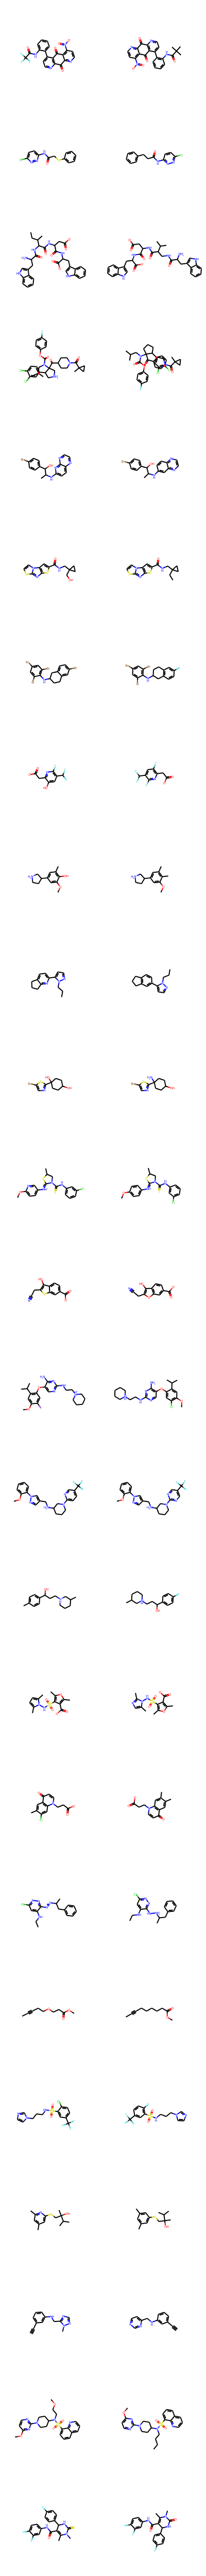

In [17]:
Chem.Draw.MolsToGridImage(mols, molsPerRow=2)

# fixed point iteration

In [18]:
from dfs_transformer.utils.rdkit import Dict2FeaturizedDFSCodes

In [23]:
collate_fn = functools.partial(dfs.collate_delete_one, 
                               mode=cfg.training.mode, 
                               fraction_missing = cfg.training.fraction_missing,
                               use_loops=cfg.model.use_loops,
                               del_idx=[4, 5, 6])
validloader = DataLoader(validset, batch_size=50, shuffle=False, 
                         pin_memory=True, collate_fn=collate_fn, num_workers=4,
                         prefetch_factor=2)
graphs1 = []
graphs2 = []
for data in tqdm.tqdm(validloader):
    data = [to_cuda(d) for d in data]
    graphs1 += bert.fwd_graph(data[0], data[1])
    padding_mask = data[0]['dfs_from'] == -1000
    preds = bert(Dict2FeaturizedDFSCodes(bert(data[0]), padding_mask))
    preds = bert(Dict2FeaturizedDFSCodes(preds, padding_mask))
    preds = bert(Dict2FeaturizedDFSCodes(preds, padding_mask))
    preds = bert(Dict2FeaturizedDFSCodes(preds, padding_mask))
    graphs2 += bert.fwd_graph(data[0], data[1], pred_codes=preds)
valid1, same1, mols1 = eval_graphs(graphs1)
valid2, same2, mols2 = eval_graphs(graphs2)

  0%|                                                                                                                                                                                       | 0/20 [00:00<?, ?it/s][W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.19it/s]


0.8990 valid molecules
0.8509 of the valid molecules stayed the same
0.6710 valid molecules
0.8197 of the valid molecules stayed the same
